<a href="https://colab.research.google.com/github/iffigueroa/eurosat-image-classification/blob/main/eurosat_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EuroSat Image Classification

## Project Overview
Satellite image classification plays a crucial role in understanding our environment, from tracking development to monitoring changes in land use and identifying environmental trends like deforestation and desertification. By classifying satellite images, we can gain insights into these changes and their impacts.

In this project, I’ll develop a Convolutional Neural Network (CNN) to classify satellite imagery, provided by Sentinel-2 satellite images from the Copernicus Earth observation program. The goal is to train multiple CNNs with varying structures and levels of data preprocessing. This approach aims to understand how different techniques and architectures affect the model's ability to classify imagery reliably.

## About the Dataset

The EuroSAT dataset is comprised of satellite images and labels from the Sentinel-2 satellite. This data is available as part of the TensorFlow dataset repository, so we’ll be able to load it directly using TensorFlow. As we’ll see after loading the data, it consists of 27,000 labeled images across 10 different land-use classifications. For additional information see: https://github.com/phelber/eurosat

## Exploratory Data Analysis & Data Preparation

In this upcoming section I am going to load the EuroSAT dataset and perform some initial analysis and prepare the data to be input into the model.

In [1]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 12.7 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Loading The Data

Since the EuroSAT dataset is available in the TensorFlow dataset repository, we can load the data directly using the `tensorflow_datasets` library. In the next section, I define a helper called `load_data` that will load dataset, and split it into both a testing and validation set to be used in building and fitting the model.

In [3]:
def load_data(dataset_name: str, test_split: float =0.2):
  assert test_split >= 0.0 and test_split <= 1.0, "Test split needs to be between 0 and 1"
  split_percent = int((1-(test_split))*100)
  (data, metadata) = tfds.load('eurosat',split=['train', f'train[:{split_percent}%]', f'train[{split_percent}%:]'],as_supervised=True,with_info=True)
  full = data[0]
  train_ds = data[1]
  test_ds = data[2]
  return full, train_ds, test_ds, metadata

test_split = 0.2
data, train, test, metadata = load_data('eurosat', test_split = test_split)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteWOZ3TB/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


### Dataset Metadata

With the data loaded, we can start to take a look at the basics about the data. The TensorFlow repos have an option to pull back metadata related to the dataset when loading the data itself. Using the code below we can inspect what metadata comes back with the data.

In [4]:
metadata

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir=PosixGPath('/tmp/tmp8b8b_16ctfds'),
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('ima

There is quite a lot of data present in the above metadata output, however, in the next few cells I pull out information that will be of interest to us as we build the model. Specifically I call out information about the size of the dataset, information about the classification labels that are used, as well as details on the imagery size and representation.

In [5]:
# Data Size
full_size = metadata.splits['train'].num_examples
test_size = int(full_size * test_split)
train_size = int(full_size - test_size)
print(f"The whole dataset contains {full_size} images.")
print(f"Since we defined a data split of {test_split}, our training set has {train_size} images and the test set has {test_size} images.")

The whole dataset contains 27000 images.
Since we defined a data split of 0.2, our training set has 21600 images and the test set has 5400 images.


In [6]:
# About the Classes
class_labels = metadata.features['label'].names
num_labels = metadata.features['label'].num_classes
class_str = "\n".join(class_labels)
print(f"There are {num_labels} class labels in this dataset.\nLables include:\n")
print(f"{class_str}")

There are 10 class labels in this dataset.
Lables include:

AnnualCrop
Forest
HerbaceousVegetation
Highway
Industrial
Pasture
PermanentCrop
Residential
River
SeaLake


In [7]:
# About the Images
IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS = metadata.features['image'].shape
print(f"Each image is of size {IMG_HEIGHT}x{IMG_WIDTH} with {NUM_CHANNELS} channels.")
print(f"Image representation type: {metadata.features['image'].dtype}")

Each image is of size 64x64 with 3 channels.
Image representation type: <dtype: 'uint8'>


### Initial Data Exploration & Analysis

Next, I aim to deepen my understanding of the dataset by conducting initial Exploratory Data Analysis (EDA). To do this, I begin by visualizing a few random sample of imagery from the dataset, accompanied by their corresponding labels.

The following images demonstrate the complexity of the problem of classification. While some of the images have distinguishing features, such as buildings and roads in Residential areas or outlines of crops in the AnnualCrop images, some images are lacking in distinguishable features. For example, Forest imagery looks largely to be a blue-green square with light texturization. Since CNNs typically are built to isolate distinct features, it may be difficult to distinguish this from say Pasture land (not pictured in this sample), but tends to have a similar look.

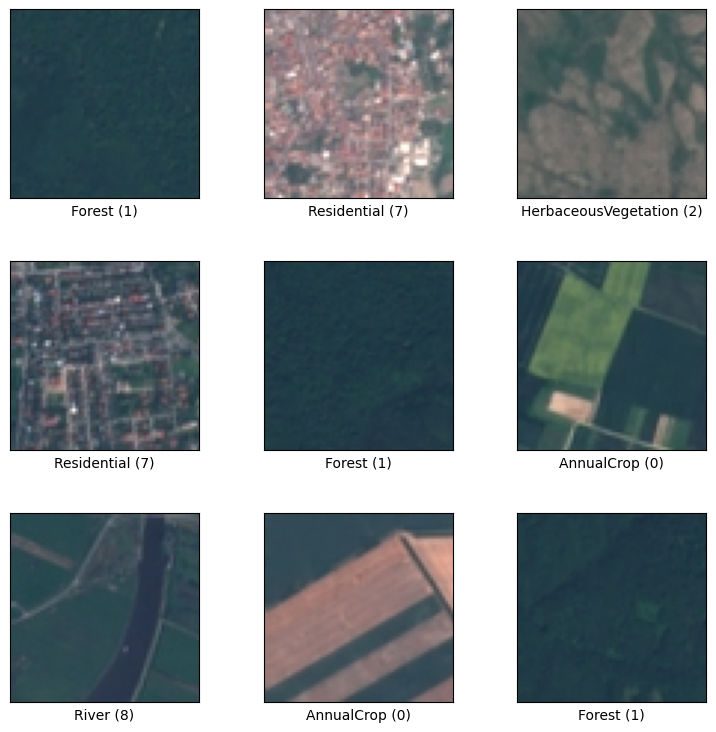

In [8]:
fig = tfds.show_examples(data, metadata)

#### Pixel Density by Channel
It may be possible that instead of picking up on physical features, the CNN may actually be able to distinguish based on colors within the image tiles. For this reason, as a part of the initial analysis, I wanted to plot the pixel distribution of a few images.

In looking at the plots below, I did notice that many of the images have higher distributions of blue and green. This is consistent with the images seen above, which all seem to primarily show blue and green unless buildings are present. While I myself can't see specific patterns in the distributions, the CNN may be able to pick up on some of this information.

In [9]:
import seaborn as sns
from matplotlib.gridspec import GridSpec
def show_image_by_channel(image, show_dist:bool = False):
    channels = {
        'red': image[:,:,0],
        'green':image[:,:,1],
        'blue':image[:,:,2],
    }
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])
    ax_kde = fig.add_subplot(gs[1, :])
    # Plot images in the top row
    for i, channel in enumerate(channels):
        ax_img = fig.add_subplot(gs[0, i])
        ax_img.imshow(channels[channel], cmap=channel.capitalize()+"s")
        ax_img.set_title(f'{channel.capitalize()} Channel')
        ax_img.axis('off')

        channel_data = channels[channel].numpy().ravel()
        sns.kdeplot(channel_data, color=channel, ax=ax_kde)

        if show_dist:
            ax_kde.set_title('Pixel Density by Channel')
            ax_kde.set_xlabel('Pixel Value')
            ax_kde.set_ylabel('Density')
            ax_kde.legend([f'{channel.capitalize()} Channel' for channel in channels])
            ax_kde.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()

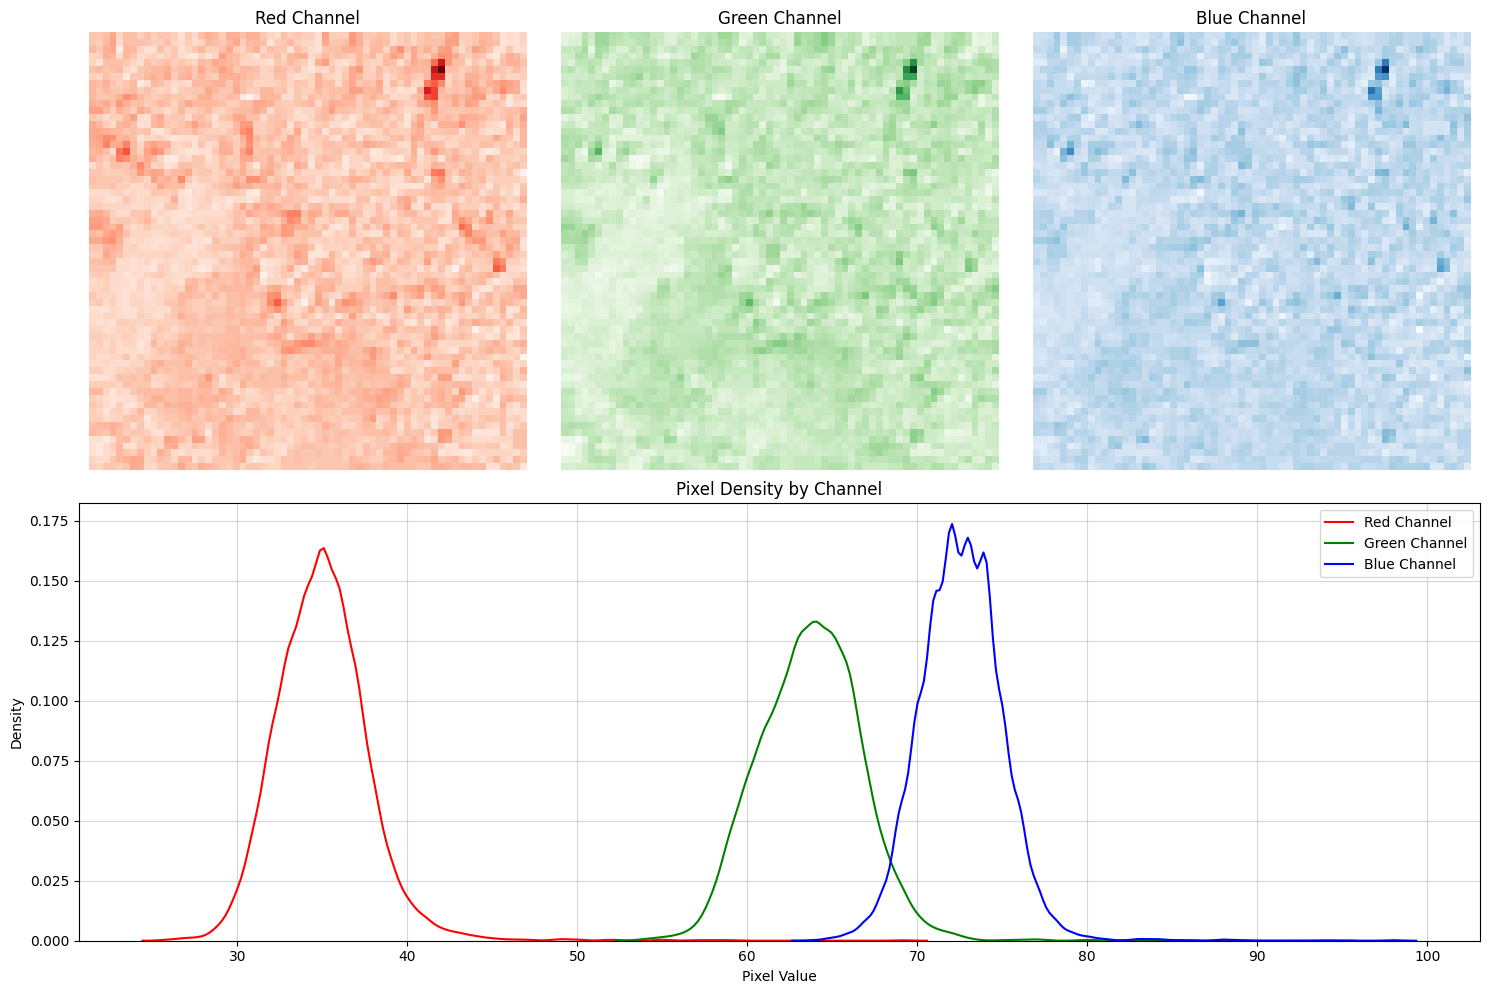

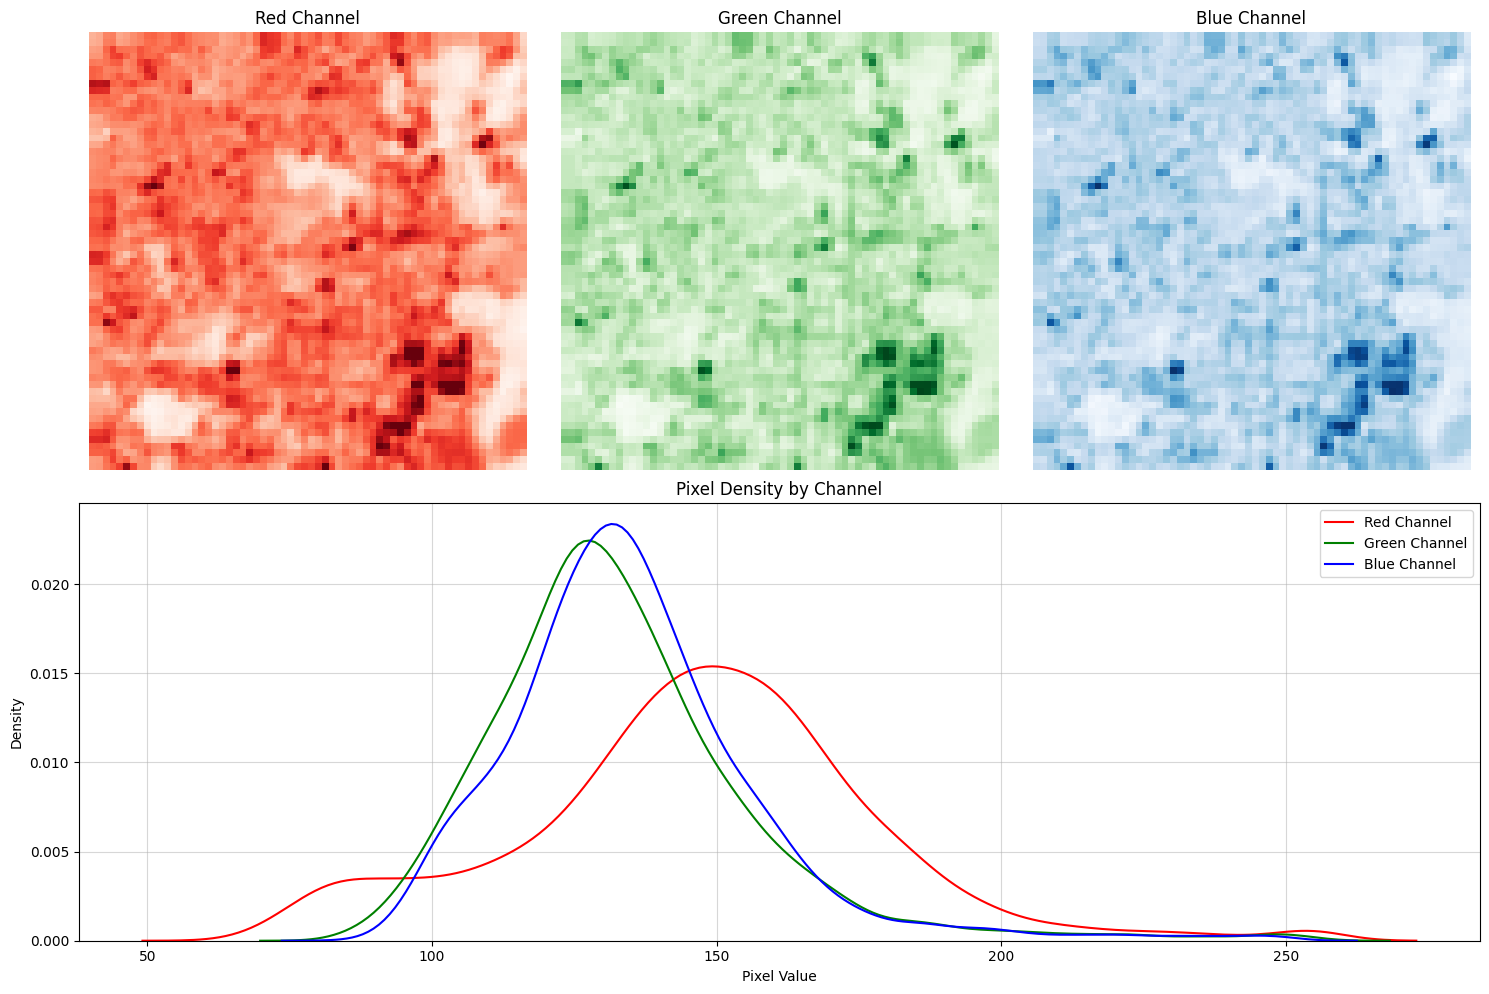

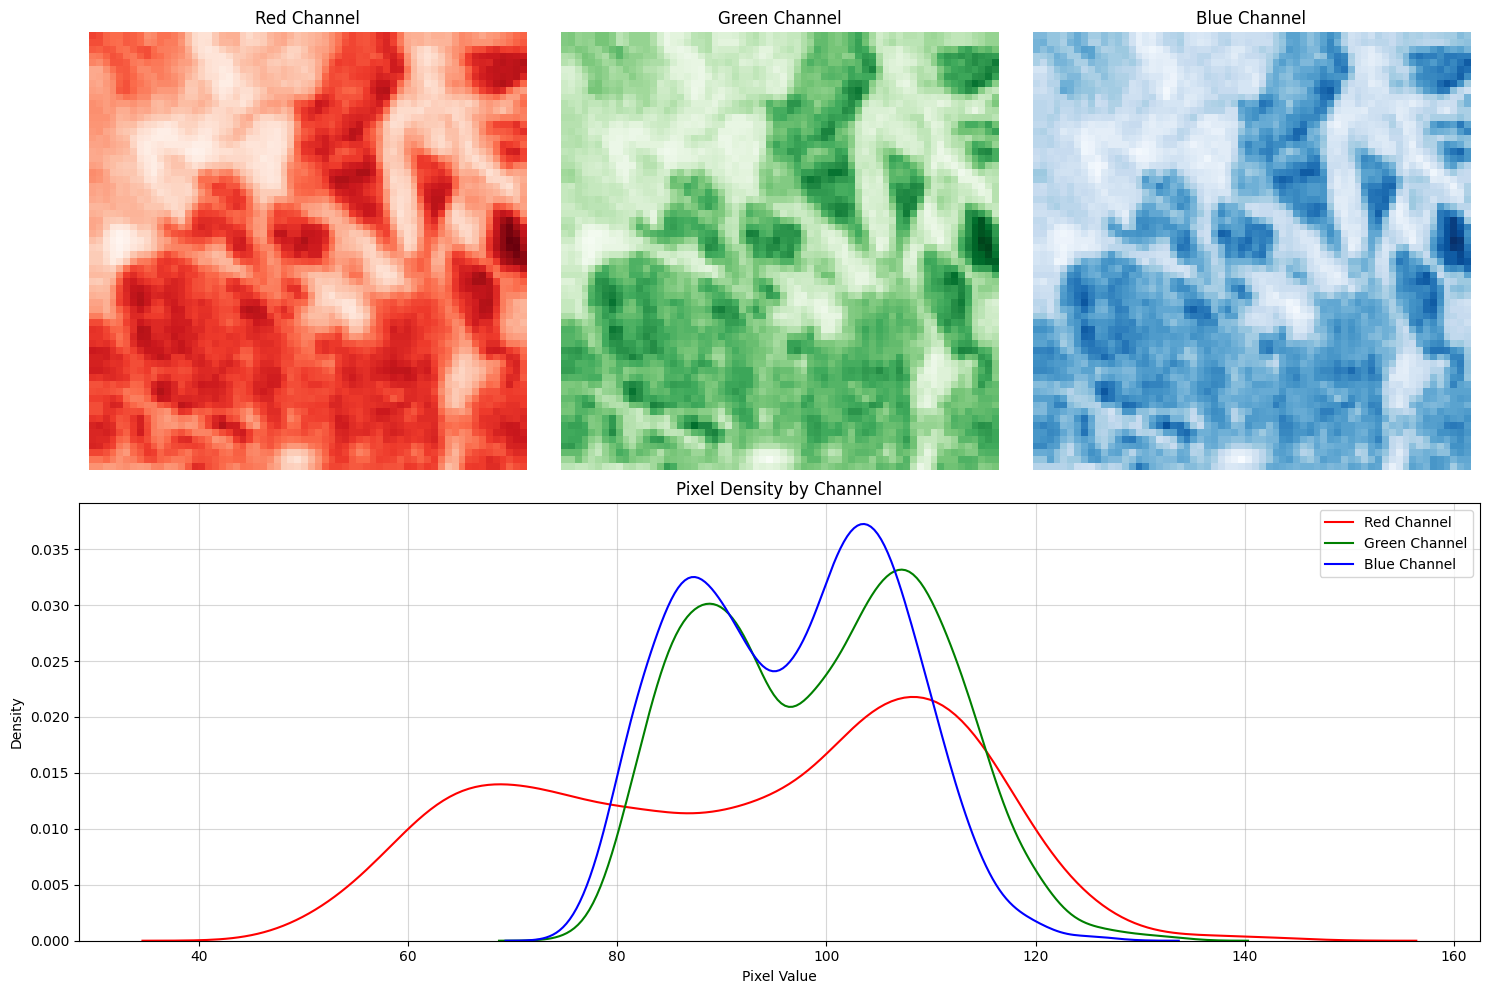

In [10]:
for i, image in enumerate(train.take(3)):
    show_image_by_channel(image[0], show_dist = True)

#### Distribution of Class Labels
Finally, before moving on to data preparation, I wanted to take a look at the distribution of the various classes within the dataset. Below I plot the distribution of the 10 classes on the entire dataset, train and test combined. While the distribution is not perfectly even, it is consistent across most class labels. For this reason, I am not going to perform any under or over sampling at this time - however I will evaluate down the line if any bias appears to be present and adjust my results analysis accordingly.  

In [11]:
def get_label_distribution(dataset, metadata, show_plot: bool = True):
  # Convert the dataset to NumPy arrays
  labels = np.array([label for _, label in tfds.as_numpy(dataset)])
  # Get the unique labels and their counts
  unique_labels, label_counts = np.unique(labels, return_counts=True)
  label_names = [metadata.features['label'].int2str(label) for label in unique_labels]
  if show_plot:
    # Plot the label distribution
    plt.figure(figsize=(12, 6))
    plt.bar(label_names, label_counts)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Labels in EuroSAT Dataset')
    plt.xticks(rotation=45)
    plt.show()
  return dict(zip(label_names, label_counts))

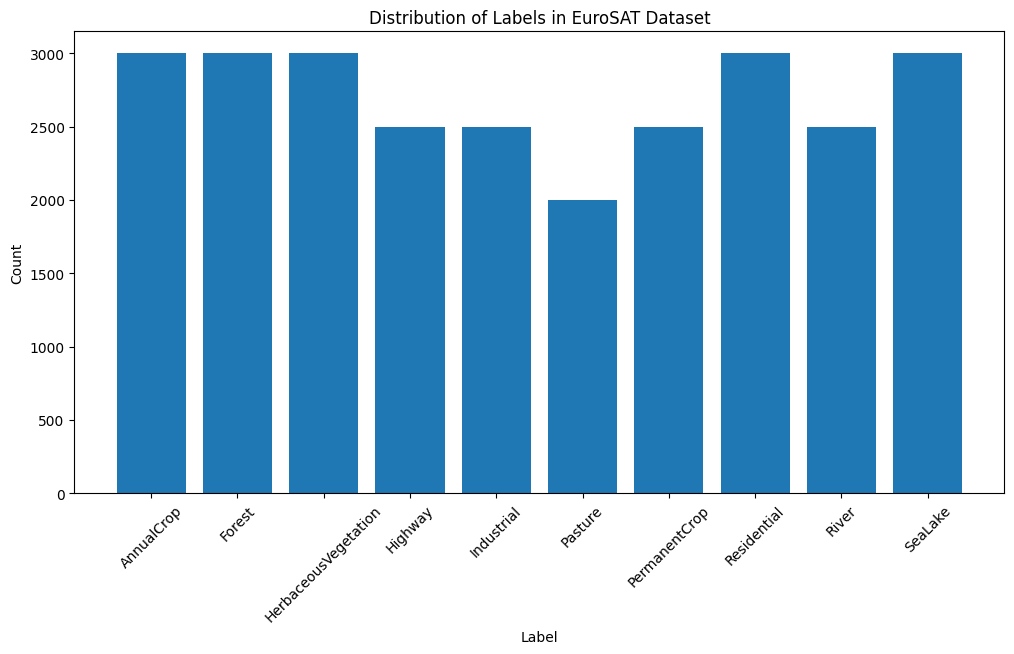

In [12]:
label_dist = get_label_distribution(data, metadata)

In [13]:
label_weights = {label: full_size / (num_labels * count) for label, count in label_dist.items()}
print(label_weights)

{'AnnualCrop': 0.9, 'Forest': 0.9, 'HerbaceousVegetation': 0.9, 'Highway': 1.08, 'Industrial': 1.08, 'Pasture': 1.35, 'PermanentCrop': 1.08, 'Residential': 0.9, 'River': 1.08, 'SeaLake': 0.9}


### Data Preparation

With the initial analysis complete I can start to prepare the data to enter the model. I will elaborate more on the model architecture in the next section, however I do know that I plan to build and evaluate three separate models. For each the following will be required:
- Optimized caching for performance
- Batch size will need to be set to 32
- Noramlization of data to scale of 0 - 1

The cell below accomplishes this:

In [14]:
# Set up caching to optimize model runs & set batch size to 32
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE).batch(32)
test = test.cache().prefetch(buffer_size=AUTOTUNE).batch(32)

In [15]:
# Normalization layer will be referenced during model building
def normalize():
  return layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS))

Additionally, I plan to build one model, where the input data is augmented. In the cell below, I define a few additional layers to be added in to the model that will perform varying levels of zoom and rotation of the images. This technique has been known to help with overfitting. During the results and final analysis we can see if applying these transformations assists in improving the model's performance.

In [ ]:
def get_augmentation_layers():
  return keras.Sequential([
      layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT,IMG_WIDTH, NUM_CHANNELS)),
      layers.RandomRotation(0.4),
      layers.RandomZoom(0.1),
    ]
  )

We can see the code above in action via the images below. As you can see, all of the images are similar but have varying rotations, flips, and levels of zoom to provide the model with more variety.

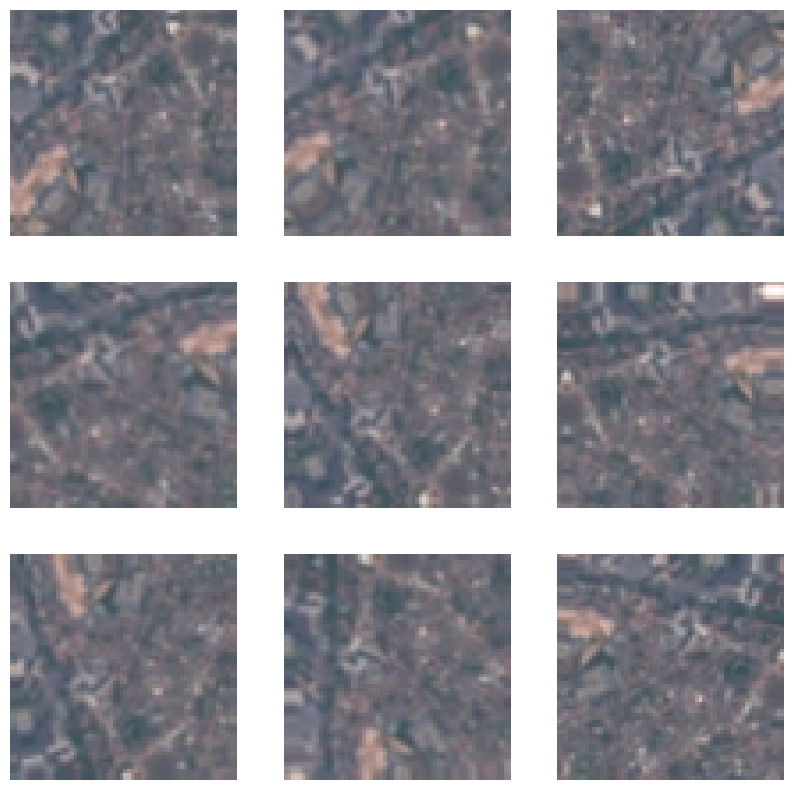

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train.take(1):
  for i in range(9):
    augmentation = get_augmentation_layers()
    augmented_images = augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Model Architecture

In this section, I will define the model architecture for three separate models. At their core the models will be largely the same, with a few minor variations. For the core architecture, I have opted for a commonly used structure, consisting of two convolutional layers followed by a layer of max pooling. To keep the model relatively simple, I will repeat this structure three times before adding a fully connected/dense layer to output the data. The first model will follow the standard structure with no deviations. For the second model, I will introduce dropout. In the third model, I will augment the data before inputting it into the model to ensure a diverse dataset.

The following cells construct these models, and will run them for a maximum of 30 epochs. I've opted also to implement early stopping based on the validation loss to save on time and to avoid overfitting the model. After building and training these models, we will compare their performance to determine the most effective approach.

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from typing import Optional
import visualkeras

def build_model(augment: bool, dropout: Optional[int]):
  layers_list = [normalize()]

  if augment:
    layers_list.append(get_augmentation_layers())

  layers_list.extend([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
  ])

  if dropout:
    layers_list.append(layers.Dropout(dropout))

  layers_list.extend([
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels)
  ])
  print(len(layers_list))
  return Sequential(layers_list)

def build_and_fit_model(augment: bool = False, dropout: Optional[float] = None, epochs: int = 5):
  early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)
  model = build_model(augment, dropout)
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  display(visualkeras.layered_view(model))
  model.summary()

  history = model.fit(
    train,
    validation_data=test,
    epochs=epochs,
    callbacks = [early_stop]
  )

  return model, history

In [18]:
TRAIN_EPOCHS = 30

### Model One: Baseline

13


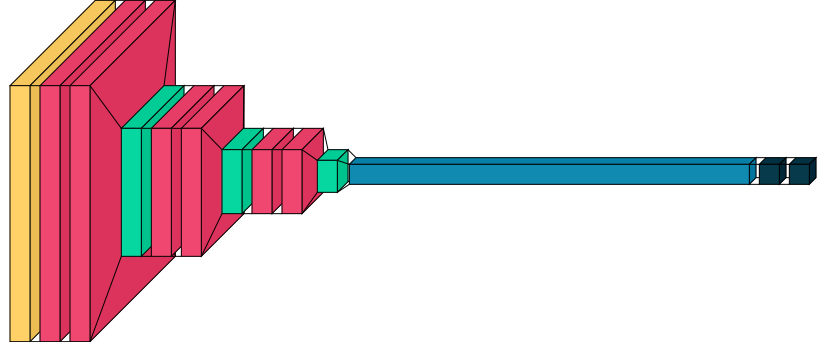

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248      
                                                      

In [19]:
model_one, hist_one =  build_and_fit_model(epochs=TRAIN_EPOCHS)

### Model Two: With Dropout

14


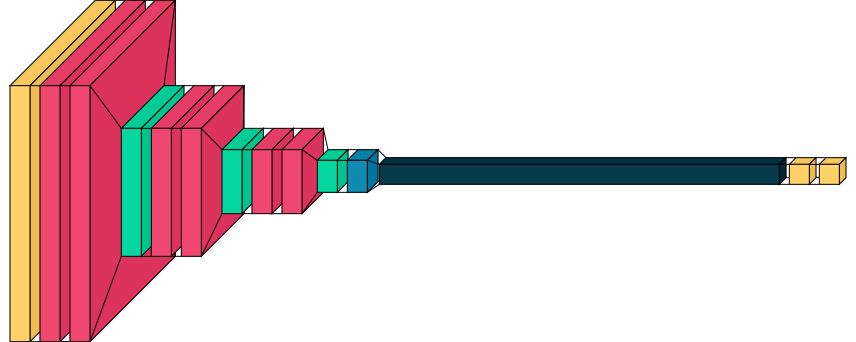

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                     

In [20]:
model_two, hist_two = build_and_fit_model(dropout = 0.2, epochs=TRAIN_EPOCHS)

### Model Three: Augmented Input Images

14


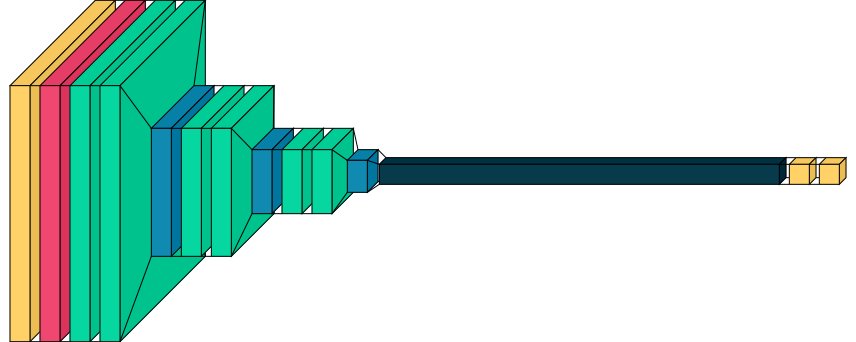

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 sequential_11 (Sequential)  (None, 64, 64, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        4640      
                                                     

In [21]:
model_three, hist_three = build_and_fit_model(augment = True, epochs=TRAIN_EPOCHS)

## Results & Analysis

Next we can take a look at the results and performance for each of the models constructed in the previous section. I will summarize the results and analysis generally here, however in the cells following I provide additional details specific to each model including:
For more detail, below I provide the following for each model:
- Overall accuracy
- Classification report
- Confusion matrix
- Plot of train and test loss and accuracy over all epochs


### General Summary

The table below is an overall summary of accuray for each model:

| Model | Accuracy |
|-------|----------|
| Model One | 0.8578 |
| Model Two | 0.8759 |
| Model Three | 0.9052 |


As we can see from the above, model three generally had the best performance with respect to accuracy. By providing more variations that the model may not have otherwise seen, it had more options to differentiate between images. This augmentation also likely helped prevent overfitting, which could have occurred in the base models, especially evident in the improved performance compared to Model One.

It's also worth noting that while Model Three achieved the highest accuracy, it was slower to converge on results, running for 19 epochs compared to 11 epochs for Models One and Two. This indicates that the data augmentation process increased the model's complexity, requiring more training iterations to reach optimal performance.

Looking at the confusion matrices revealed that some labels were consistently confused across all models. For example, the classes AnnualCrop and PermanentCrop were quite often confused for each other. As well, Highways and Herbaceous vegetation, showed recurring classification issues. In Model Three, although misclassifications still occurred, they appeared to be more focused, so we see fewer misclassifications between multiple classes and more misclassifications with one or two other classes, possibly indicating a more refined understanding of the features that make up each class.

Overall, the results suggest that incorporating data augmentation techniques, such as those used in Model Three, and adding in dropout as in Model Two, can significantly improve the accuracy and robustness of CNN models for satellite image classification tasks.


In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_predictions(model, test_data):
  print("Classification Report")
  predictions = model.predict(test_data)
  y_true = np.concatenate([label for _, label in tfds.as_numpy(test_data)])
  y_pred = np.argmax(predictions, axis=1)
  print(classification_report(y_true, y_pred))
  return y_true, y_pred

def show_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)

  # Plot the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

def plot_model_history(history):
  fig, axs = plt.subplots(1, 2, figsize=(20, 6))

  axs[0].plot(history.history['loss'])
  axs[0].plot(history.history['val_loss'])
  axs[0].set_title('Model Loss')
  axs[0].set_ylabel('Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['Train', 'Validation'], loc='upper right')

  axs[1].plot(history.history['accuracy'])
  axs[1].plot(history.history['val_accuracy'])
  axs[1].set_title('Model Accuracy')
  axs[1].set_ylabel('Accuracy')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['Train', 'Validation'], loc='lower right')
  plt.show()


def evaluate_results(model, history, test_data):
  print("Summary of Accuracy")
  model.evaluate(test_data)
  labels, predicted = make_predictions(model, test_data)
  show_confusion_matrix(labels, predicted)
  plot_model_history(history)


### Model One Results

Summary of Accuracy
169/169 [==============================] - 17s 103ms/step - loss: 0.5837 - accuracy: 0.8578
Classification Report
169/169 [==============================] - 23s 132ms/step
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       573
           1       0.99      0.97      0.98       575
           2       0.87      0.66      0.75       621
           3       0.80      0.76      0.78       504
           4       0.88      0.91      0.90       501
           5       0.93      0.85      0.89       397
           6       0.59      0.88      0.71       504
           7       0.97      0.92      0.94       608
           8       0.91      0.75      0.82       511
           9       0.99      0.96      0.97       606

    accuracy                           0.86      5400
   macro avg       0.87      0.86      0.86      5400
weighted avg       0.87      0.86      0.86      5400



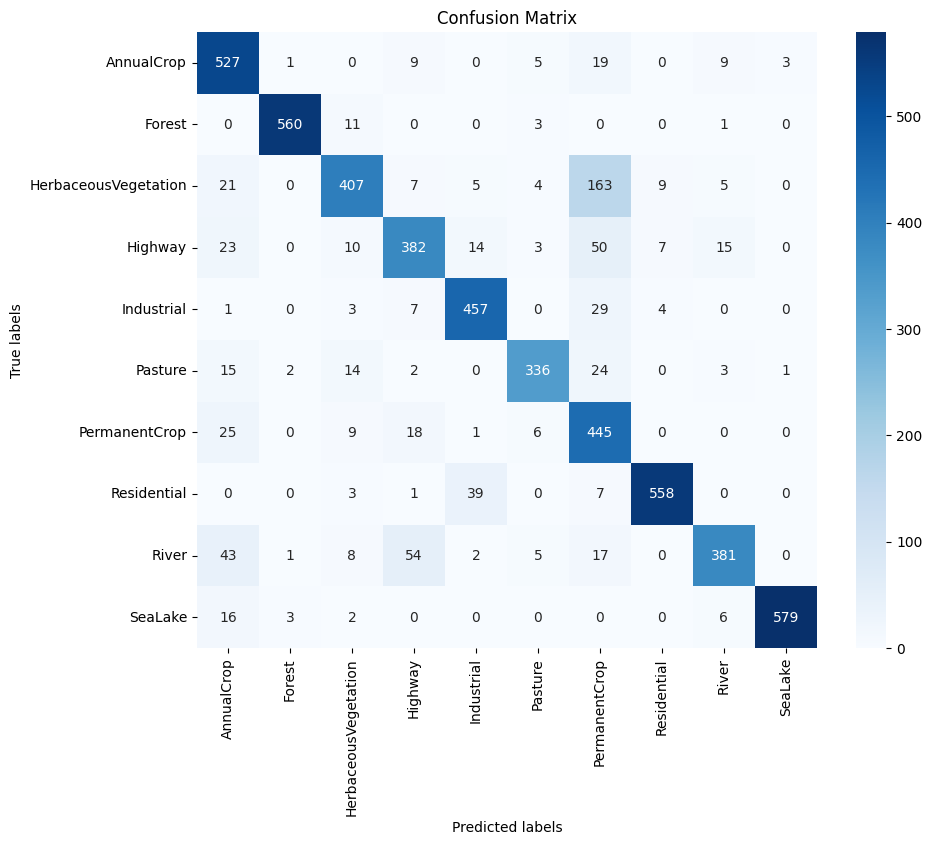

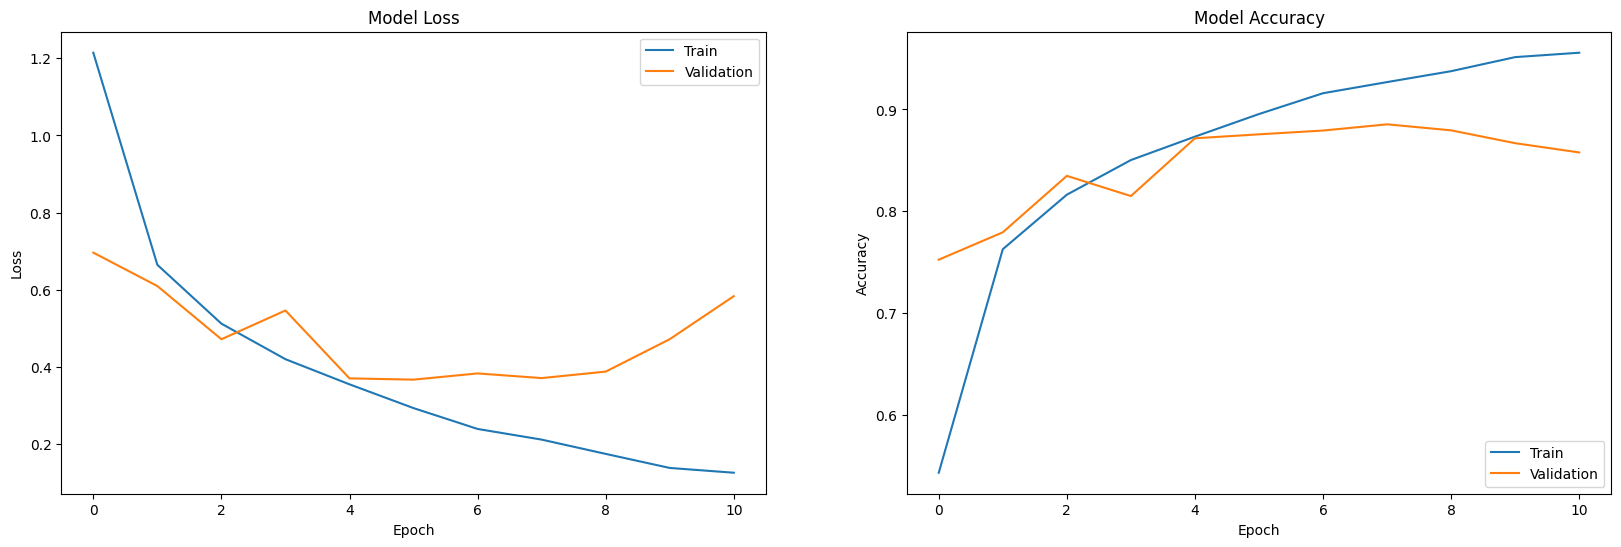

In [23]:
evaluate_results(model_one, hist_one, test)

### Model Two Results

Summary of Accuracy
169/169 [==============================] - 22s 128ms/step - loss: 0.4278 - accuracy: 0.8759
Classification Report
169/169 [==============================] - 22s 132ms/step
              precision    recall  f1-score   support

           0       0.94      0.84      0.88       573
           1       0.96      0.96      0.96       575
           2       0.83      0.79      0.81       621
           3       0.71      0.84      0.77       504
           4       0.87      0.97      0.92       501
           5       0.90      0.86      0.88       397
           6       0.72      0.77      0.75       504
           7       0.95      0.95      0.95       608
           8       0.91      0.78      0.84       511
           9       0.99      0.97      0.98       606

    accuracy                           0.88      5400
   macro avg       0.88      0.87      0.87      5400
weighted avg       0.88      0.88      0.88      5400



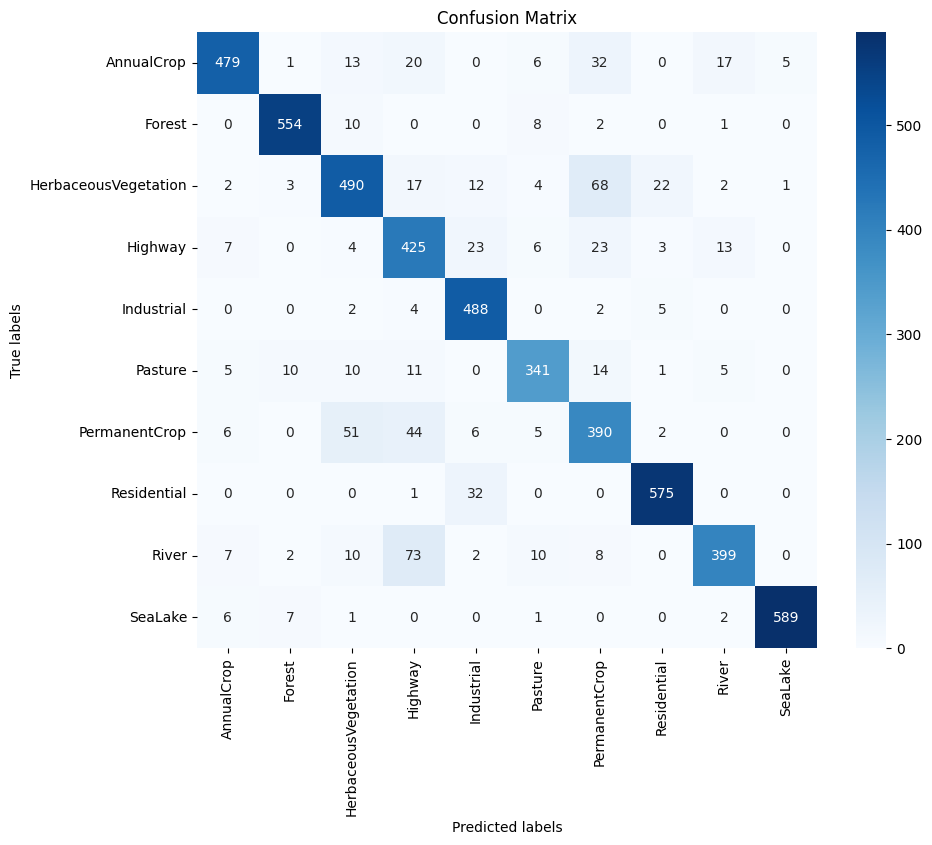

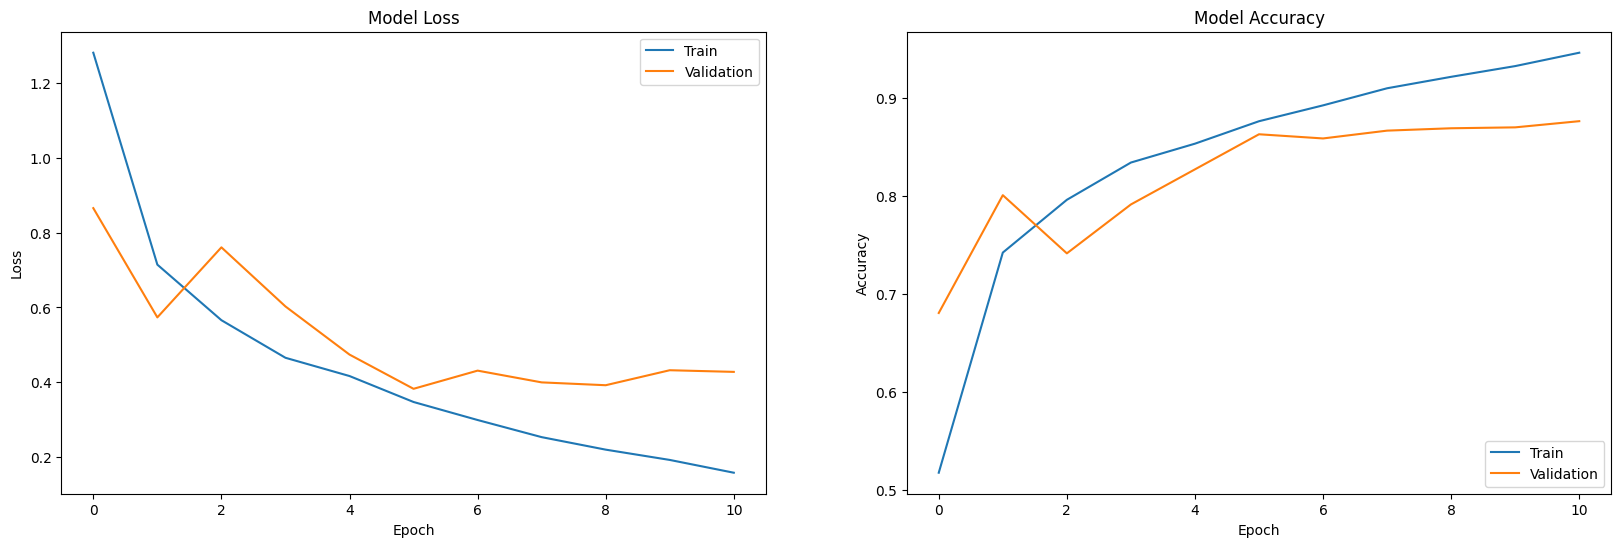

In [24]:
evaluate_results(model_two, hist_two, test)

### Model Three Results

Summary of Accuracy
169/169 [==============================] - 24s 144ms/step - loss: 0.2856 - accuracy: 0.9052
Classification Report
169/169 [==============================] - 25s 145ms/step
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       573
           1       0.94      0.99      0.97       575
           2       0.87      0.82      0.84       621
           3       0.95      0.86      0.90       504
           4       0.86      0.99      0.92       501
           5       0.89      0.93      0.91       397
           6       0.84      0.80      0.82       504
           7       0.85      0.97      0.91       608
           8       0.92      0.91      0.92       511
           9       0.98      0.95      0.97       606

    accuracy                           0.91      5400
   macro avg       0.91      0.91      0.90      5400
weighted avg       0.91      0.91      0.90      5400



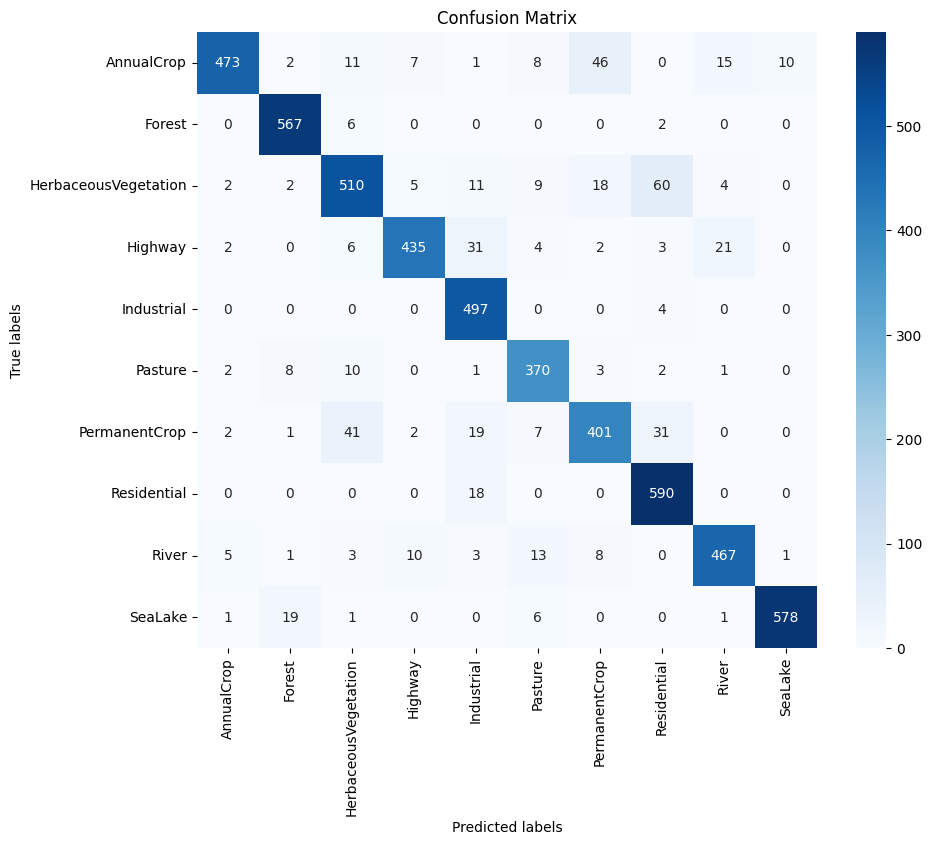

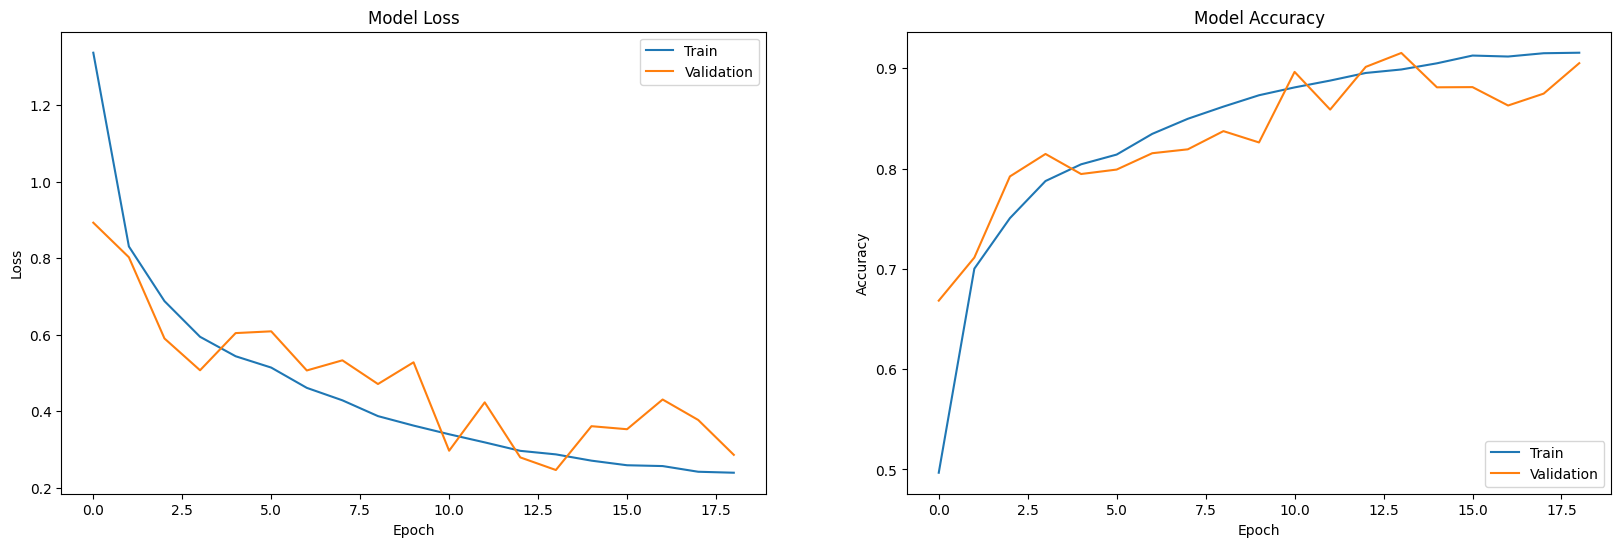

In [25]:
evaluate_results(model_three, hist_three, test)

### Plotting Incorrectly Classified Images

Finally, before moving on to the conclusions, I visualized a sample of images that were incorrectly classified by our best-performing model. Some of the misclassifications may not be intuitive to a human, who may be more likely to correctly classify the images. For example, why would a Sea Lake be misconstrued for an Annual Crop instead of a Forest?

However, we can also observe that some misclassifications make sense. For instance, in one instance, a highway is predicted to be a river. While a human observer may differentiate between the two, we can see that the model recognizes key features common to both, such as a narrow corridor running through an image. This indicates that the model is capable of identifying certain structural similarities, even if the end classification isn't quite right.

In [28]:
predictions = model_three.predict(test)


169/169 [==============================] - 22s 129ms/step


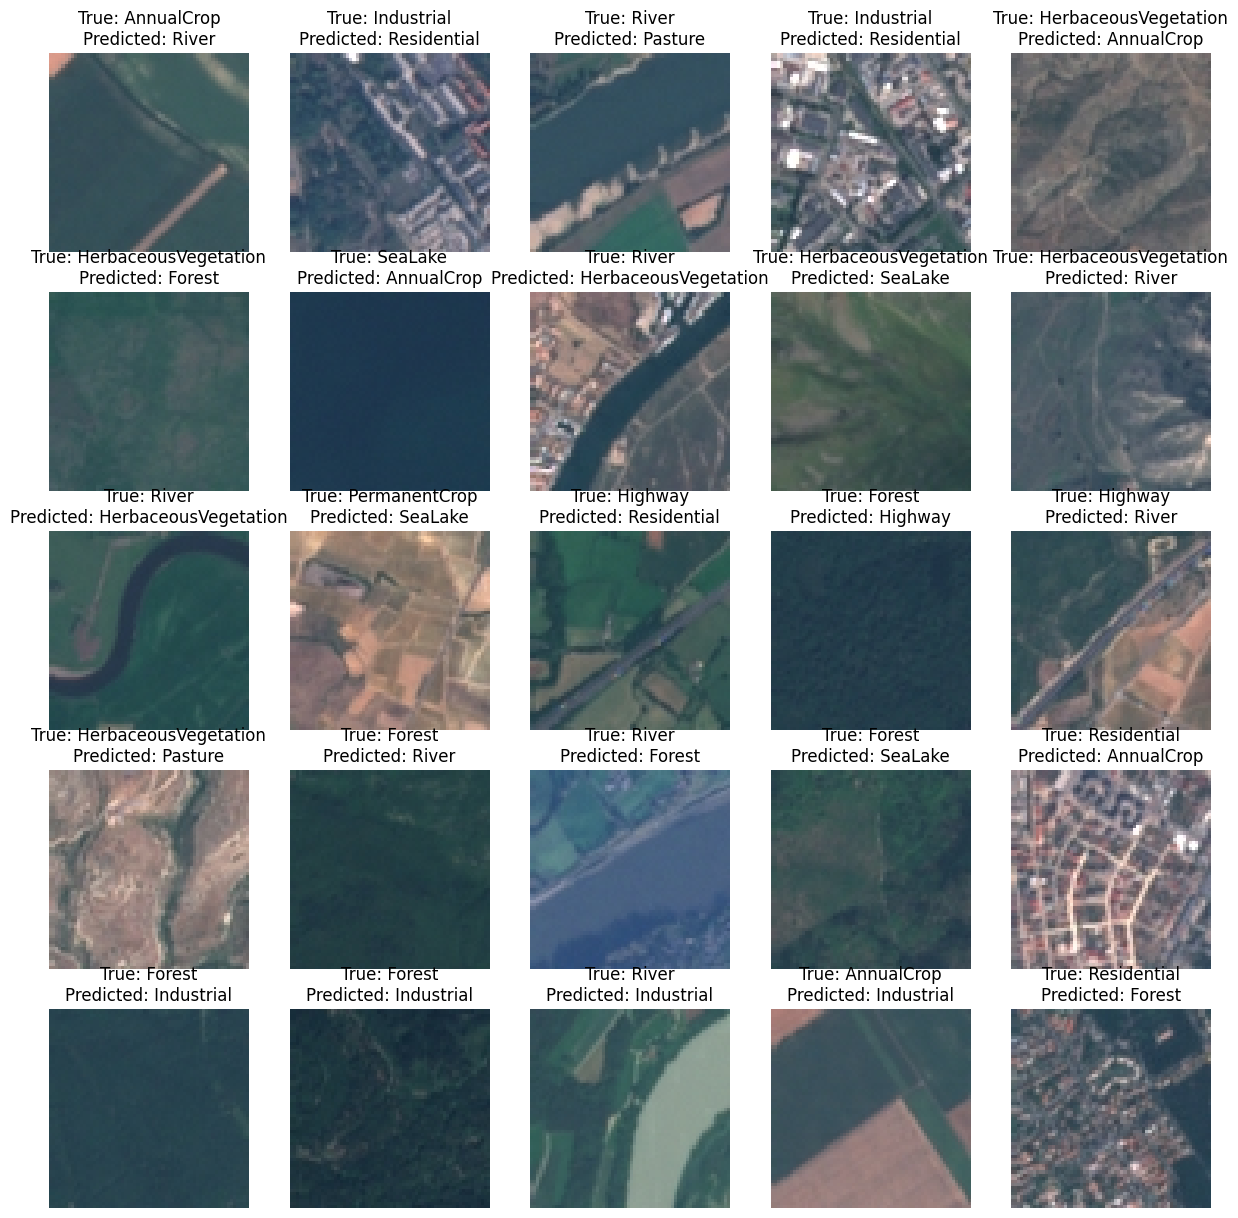

In [29]:
import matplotlib.pyplot as plt

def show_incorrect_classifications(dataset,  metadata, predictions):
  plt.figure(figsize=(15, 15))
  num_images = 0
  for images, labels in tfds.as_numpy(dataset):
    for i, image in enumerate(images):
      p = np.argmax(predictions[i])
      if p != labels[i]:
        image = image.reshape((64, 64, 3))
        plt.subplot(5, 5, num_images + 1)
        plt.imshow(image)
        plt.axis('off')
        label_name = metadata.features['label'].int2str(labels[i])
        predicted_name = metadata.features['label'].int2str(p)
        plt.title(f'True: {label_name}\nPredicted: {predicted_name}')
        num_images += 1
      if num_images == 25:
        return
  plt.tight_layout()
  plt.show()


show_incorrect_classifications(test, metadata, predictions)


## Conclusions

In this notebook, we explored the effectiveness of different CNN architectures for satellite image classification.

Model One's performance was not bad as a base model, however, Models Two and Three demonstrated notable improvements. Model Two, with dropout added, showed enhanced performance compared to the base model, indicating the effectiveness of dropout in mitigating overfitting. Model Three, which incorporated data augmentation, outperformed the others with an accuracy of approximately 90%. This suggests that augmenting the data provided additional variations for the model to learn from and helped prevent overfitting.

Possible future work includes exploring different, more complex base structures. Additionally, while there are no apparent biases in the data, running on a perfectly balanced dataset could confirm this and further improve the model's performance. And finally, I would like to see the results of combining both dropout and data augmentation on the model performance.


### Quick References:

- https://www.tensorflow.org/datasets/overview
- https://www.tensorflow.org/tutorials/images/classification
- https://www.geeksforgeeks.org/python-image-classification-using-keras/
- https://kvirajdatt.medium.com/starting-with-tensorflow-datasets-part-2-intro-to-tfds-and-its-methods-32d3ac36420f
- https://www.tensorflow.org/datasets/splits
- https://github.com/phelber/EuroSAT
- https://www.geeksforgeeks.org/classification-on-imbalanced-data-using-tensorflow/